A linear predictors is a linear function (linear combination) of a set of coefficients and explanatory variables (independent variables), whose value is used to predict the outcome of a dependent variable.

Many learning algorithms rely on linear predictors. Moreover, linear predictors are intuitive, easy to inerpret and fit the data reasonably well in many natural learning problems

Linera predictors are besd on the class of affine functions

$$ L_d = \{\mathbf x \mapsto \langle\mathbf w, \mathbf x\rangle + b:\mathbf w \in \mathbb R^d, b \in \mathbb R\} $$

Each function $h_{\mathbf w,b}$ is parametrized by a vector $\mathbf w$ that define a linear transformation and a scalar $b$ that define a translation.
Usually the term $b$, called *bias* is incorporated into $\mathbf w$ as an extra coordinate, adding also an extra coordinate with value 1 to all $\mathbf x \in \mathcal X$

$$ \mathbf w' =\begin{pmatrix}b, w_1, \ldots, w_d\end{pmatrix} \qquad \mathbf x' = \begin{pmatrix}1, x_1, \ldots, x_d\end{pmatrix}$$

## Halfspaces

A function $h_{\mathbf w,b}$ defines an hyperplane in the space $\mathbb R$ that divide this into two subsapces called *half-spaces*. The hypothesis class of halfspaces is designed for binary classification problems, namely $\mathcal X=\mathbb R^d$ and $\mathcal Y =\{-1,+1\}$. The class of half-spaces is defined as follows:

$$ HS_d = \text{sign}\circ L_d = \{\mathbf x \mapsto \text{sign}(h_{\mathbf w,b}(\mathbf x)) : h_{\mathbf w,b} \in L_d\}$$

Consider the 2-dimensional case. Each hypothesis define an hyperplane that is perpendicular to the vector $\mathbf w$ and separates the space into two sub-spaces:

- the points *above* the hyperplane (that share an acute angle with $\mathbf w$) are labeled positively
- the points *below* the hyperplane (that share an obtuse angle with $\mathbf w$) are labeled negatively

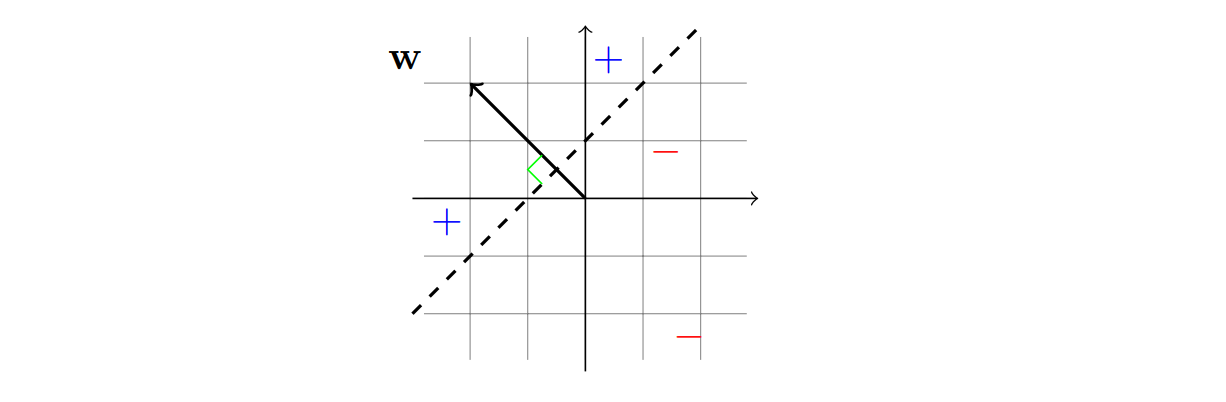

In the condition of **realizability assumption** (namely the points of the two classes are linearly separable), the ERM problem for halfspaces can be expressed as a linear program, that is an optimization problem of a *linear function* under *linear constraints*.

Let $S = \{(\mathbf x_i, y_i)\}_{i=1}^m$ be a training set of size $m$. From the realizability assumption follows that an ERM predictor should have zero errors on the training set. Or equivalently that exists at least a vector $\mathbf w^*$ such that:

$$ \text{sign}(\langle\mathbf w^*, \mathbf x_i\rangle) = y_i,\qquad \forall i = 1, \ldots, m$$

Considering the closest point to the hyperplane $\gamma = \min_i(y_i\langle\mathbf w^*, \mathbf x_i\rangle)$ we can define the vector $\mathbf{\bar w} = \frac{\mathbf w^*}{\gamma} $. Therefore foreach $i$:

$$ y_i\langle\mathbf{\bar w}, \mathbf x_i\rangle = \frac{1}{\gamma}y_i\langle\mathbf w^*, \mathbf x_i\rangle = \frac{y_i\langle\mathbf w^*, \mathbf x_i\rangle}{\min_i(y_i\langle\mathbf w^*, \mathbf x_i\rangle)} \ge 1 $$

Letting $A\in\mathbb R ^{m\times d}$ be the matrix whose elements are defined as $A_{i,j} = y_ix_{i,j}$ and letting $\mathbf v = \begin{pmatrix} 1, 1, \ldots,1\end{pmatrix}\in\mathbb R^m$, the equation above can be rewritten as a linear program:

$$ A\mathbf w \ge \mathbf v $$

Note that since all the vectors that satisfy this constraint are euqally good candidates, we can set a dummy objective $u = \begin{pmatrix} 0,0,\ldots,0\end{pmatrix}\in\mathbb R^d$

### Code implementation

We start generating the set of samples $S = \{(\mathbf x_i, y_i)\}_{i=1}^m$. In this case we will consider a simple set of 20 2D points. Remeber that we need to assure realizability assumption, namely that the points of the two classes are linearly separable, in order to make the magic happen. I have defined a separating line $y = 2*x + 5$ and then generated ten points of the class $"+"$ (above the line) and ten points of the class $"-"$ (below the line)

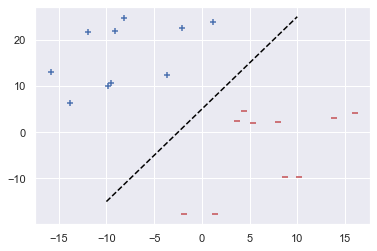

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

separating_line = lambda x: 2*x + 5

n_pos_points = 10
n_neg_points = 10

x_pos = np.array([(x - 15*np.random.rand(), separating_line(x) + 15*np.random.rand()) for x in np.random.randint(-5, 5, n_pos_points)])
x_neg = np.array([(x + 15*np.random.rand(), separating_line(x) - 15*np.random.rand())for x in np.random.randint(-5, 5, n_pos_points)])

plt.scatter(x_pos[:,0], x_pos[:,1], c='b', marker='+')
plt.scatter(x_neg[:,0], x_neg[:,1], c='r', marker='_')
plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')

To perform the computation of an halfspace I will make advantage of the LP library PuLP. First of all I define the set of points $X = \{\mathbf x_i = (x_{i,1}, x_{i,2})\}_{i=1}^m$ and the set of labels $y = \{y_i\}_{i=1}^m$. Then I define the dummy vector $u$ the matrix $A$ as defined above. There is no need to explicitly define the constraint vector $v$ since the constraints will be added one at a time.

In [16]:
from pulp import *  

X = np.vstack((x_pos, x_neg)) #points
y = np.hstack((np.ones(len(x_pos)), -1 * np.ones(len(x_neg)))) #labels

u = np.zeros(2)
A = X *y[:,np.newaxis]
# v = np.ones(len(X))*1.0

# Create the model
model = LpProblem(name="small-problem", sense=LpMaximize)

# Initialize the decision variables
x1 = LpVariable(name="x1", lowBound=-10)
x2 = LpVariable(name="x2", lowBound=-10)

# Adding constraints Aw > v
for i in range(len(A)):
    model += (A[i][0]*x1 + A[i][1]*x2 >= 1, f"{i}-constraints")

# model += A @ (x, y) >= [1] * len(A)
obj_func = 1.0*x1 + 1.0*x2
model += obj_func

In [17]:
model

small-problem:
MAXIMIZE
1.0*x1 + 1.0*x2 + 0.0
SUBJECT TO
0_constraints: - 9.84786956697 x1 + 10.0980973707 x2 >= 1

1_constraints: - 11.9330546123 x1 + 21.6603979006 x2 >= 1

2_constraints: - 13.8678317066 x1 + 6.35634598223 x2 >= 1

3_constraints: - 15.8567636566 x1 + 13.1038273137 x2 >= 1

4_constraints: - 3.65391527595 x1 + 12.4953991222 x2 >= 1

5_constraints: - 9.54112672477 x1 + 10.7052628577 x2 >= 1

6_constraints: 1.14852517134 x1 + 23.7701893976 x2 >= 1

7_constraints: - 9.1392415992 x1 + 21.8933142395 x2 >= 1

8_constraints: - 2.0406273483 x1 + 22.597247253 x2 >= 1

9_constraints: - 8.11774385242 x1 + 24.6356657577 x2 >= 1

10_constraints: 1.8787318831 x1 + 17.7697227615 x2 >= 1

11_constraints: - 16.0435559318 x1 - 4.14481592668 x2 >= 1

12_constraints: - 1.37132728672 x1 + 17.7850675663 x2 >= 1

13_constraints: - 5.33742648086 x1 - 1.96452504072 x2 >= 1

14_constraints: - 7.93519739387 x1 - 2.25915714363 x2 >= 1

15_constraints: - 13.8156181942 x1 - 3.12090263654 x2 >= 1

1

In [18]:
status = model.solve()
print(f"Completed successfully: {status == 1}")

Completed successfully: True


Finally to test the results of the model, we can retrieve the computed normal vector $w$ that defines the computed separating hyperplane, compute the predicted labels as <code>np.sign(X @ w)</code> and plot the results. As we can see the model is perfectly able to find a possible separating hyperplane.

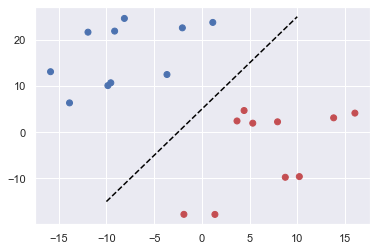

In [19]:
w = np.array([model.variables()[0].value(), model.variables()[1].value()])
y_pred = np.sign(X @ w)

colors = ['b' if y == 1.0 else 'r' for y in y_pred ]
plt.scatter(X[:,0], X[:,1], c=colors)
plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')

## Perceptron

Perceptron is a linear predictor based on an iterative algorithm. At the beginning the vector $\mathbf w^{(0)}$ is initialized randomly. Then, at each iteration $t$, the Perceptron finds an example $i$ that is mislabeled by $\mathbf w^{(t)}$ or mathematically a sample $\mathbf x_i$ such that $\text{sign}(\langle\mathbf w^{(t)}, \mathbf x_i\rangle)\neq y_i$ and updates it current vector as:

$$\mathbf w^{(t+1)} =\mathbf w^{(t)} + y_i\mathbf x_i $$

What this update practically does is to move the boundary in the direction of $\mathbf x_i$ in order to make a correct prediction on this sample

<img src='https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/Perceptron/PerceptronUpdate.png'>

In [29]:
class Perceptron():
    def show(self, X, y):
        pos_mask = y == 1
        neg_mask = y == -1
        plt.scatter(X[pos_mask, 0],X[pos_mask, 1], c='b', marker='+')
        plt.scatter(X[neg_mask, 0], X[neg_mask, 1], c='r', marker='_')
#         plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')
        plt.arrow(0, 0, self.w[0]+self.w[1], self.w[2], color = 'black')
        plt.show()
    
    def train(self, X, y, w=None):
        m,n = X.shape
        
        self.w = np.ones(n + 1)
        self.w = self.w/np.linalg.norm(self.w)
        self.show(X, y)
        
        while True:
            stop_flag = True
            
            for i in range(m):
                x = np.insert(X[i], 0, 1)
                
                if y[i] * (self.w @ x) <= 0:
                    self.w = self.w + y[i] * x
                    self.w = self.w/np.linalg.norm(self.w)
                    stop_flag = False
                    self.show(X, y)
                    
            if stop_flag:
                return
    
    def predict(self, X):
        return np.sign(np.hstack((np.ones(X.shape[0])[:, np.newaxis], X)) @ self.w)

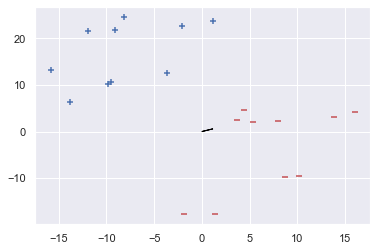

(2,)
(2,)
(2,)


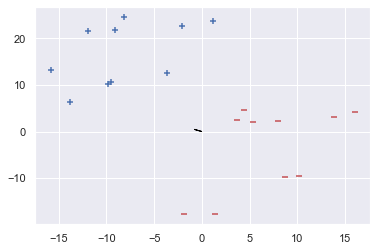

(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)


In [30]:
model = Perceptron()
model.train(X, y)

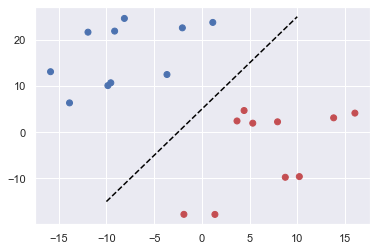

In [32]:
y_pred = model.predict(X)
colors = ['b' if y == 1.0 else 'r' for y in y_pred ]
plt.scatter(X[:,0], X[:,1], c=colors)
plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')

In [33]:
np.hstack((np.ones(X.shape[0])[:, np.newaxis], X))

array([[  1.        ,  -9.84786957,  10.09809737],
       [  1.        , -11.93305461,  21.6603979 ],
       [  1.        , -13.86783171,   6.35634598],
       [  1.        , -15.85676366,  13.10382731],
       [  1.        ,  -3.65391528,  12.49539912],
       [  1.        ,  -9.54112672,  10.70526286],
       [  1.        ,   1.14852517,  23.7701894 ],
       [  1.        ,  -9.1392416 ,  21.89331424],
       [  1.        ,  -2.04062735,  22.59724725],
       [  1.        ,  -8.11774385,  24.63566576],
       [  1.        ,  -1.87873188, -17.76972276],
       [  1.        ,  16.04355593,   4.14481593],
       [  1.        ,   1.37132729, -17.78506757],
       [  1.        ,   5.33742648,   1.96452504],
       [  1.        ,   7.93519739,   2.25915714],
       [  1.        ,  13.81561819,   3.12090264],
       [  1.        ,   4.42874202,   4.70227306],
       [  1.        ,   3.68683772,   2.44339862],
       [  1.        ,   8.74841871,  -9.74422823],
       [  1.        ,  10.21906

In [ ]:
X @ w

In [ ]:
X @ w.T

In [ ]:
y_predxx

In [ ]:
status